![](https://i.ytimg.com/vi/bYeBL92v99Y/maxresdefault.jpg)

<h1 align="center">Simple Linear Model</h1>

# 1. Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
print (tf.__version__)

1.0.0


# 2. Load Data

In [3]:
# Load MNIST data-set
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


# 3. One-hot Encoding
The data-set has been loaded as so called One-Hot encoding. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i^{th}$ element which is one and means the class is $i$.

Example:

In [5]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

We also need the classes as single numbers for various comparisons and performance measures, so we convert the One-Hot encoded vectors to a single number by taking the index of the highest element. 

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

# 4. Data dimensions

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

# 5. Helper Function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
            
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        # Remove ticks from plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
       

# 6. Plot a few images to see if data is correct

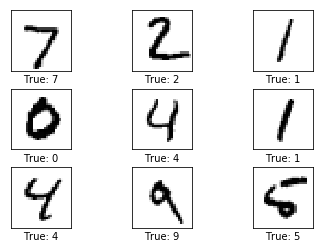

In [10]:
# Get the first images from the test set
images = data.test.images[0:9]

# Get the true classes for those images
cls_true = data.test.cls[0:9]

# Plot the images and labels using the helper-function
plot_images(images=images, cls_true=cls_true)

# 7. TensorFlow Graph

A TensorFlow graph consists of the following parts:
- Placeholder variables used to change the input to the graph.
- Model variables that are going to be optimized so as to make the model perform better.
- The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
- A cost measure that can be used to guide the optimization of the variables.
- An optimization method which updates the variables of the model.


In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard.

## Placeholder variables
Placeholder variables serve as the input to the graph that we may change each time we execute the graph. 

Let's define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to ```[None, img_size_flat]```, where None means that the tensor may hold an arbitrary number of images with each image being a vector of length ```img_size_flat```.

In [11]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is ```[None, num_classes]``` which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [12]:
y_true = tf.placeholder(tf.int64, [None, num_classes])

Finally we have the placeholder variable for the true class of each image in the placeholder variable x. These are integers and the dimensionality of this placeholder variable is set to [None] which means the placeholder variable is a one-dimensional vector of arbitrary length.

In [13]:
y_true_cls = tf.placeholder(tf.int64, [None])

## Variables to be optimized
Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.
The first variable that must be optimized is called weights and is defined here as a TensorFlow variable that must be initialized with zeros and whose shape is ```[img_size_flat, num_classes]```, so it is a 2-dimensional tensor (or matrix) with ```img_size_flat``` rows and ```num_classes``` columns.


In [14]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

The second variable that must be optimized is called biases and is defined as a 1-dimensional tensor (or vector) of length num_classes.

In [15]:
biases = tf.Variable(tf.zeros([num_classes]))

## Model
This simple mathematical model multiplies the images in the placeholder variable x with the weights and then adds the biases.

The result is a matrix of shape ```[num_images, num_classes]``` because x has shape ```[num_images, img_size_flat]``` and weights has shape ```[img_size_flat, num_classes]```, so the multiplication of those two matrices is a matrix with shape ```[num_images, num_classes]``` and then the biases vector is added to each row of that matrix.

Note that the name logits is typical TensorFlow terminology, but other people may call the variable something else.

In [16]:
logits = tf.matmul(x, weights) + biases

Now logits is a matrix with ```num_images``` rows and ```num_classes``` columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.

However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the ```logits``` matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in ```y_pred```.

In [17]:
y_pred = tf.nn.softmax(logits)


The predicted class can be calculated from the ```y_pred``` matrix by taking the index of the largest element in each row.

In [18]:
y_pred_cls = tf.arg_max(y_pred, dimension=1)

## Cost-function to be optimized
To make the model better at classifying the input images, we must somehow change the variables for ```weights``` and ```biases```. To do this we first need to know how well the model currently performs by comparing the predicted output of the model ```y_pred``` to the desired output ```y_true```.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the weights and biases of the model.

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the logits because it also calculates the softmax internally.

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [20]:
cost = tf.reduce_mean(cross_entropy)